In [1]:
%matplotlib inline
%load_ext autoreload
from spectral_cube import SpectralCube
from aplpy import FITSFigure
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
import warnings
import numpy as np
import shells
from scipy.ndimage.filters import gaussian_filter
%aimport shell_model
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Fixing Model Cloud Parameters for Orion A
distance: 414 pc (Menten+ 2007)

thickness: 1 pc (upper limit: ~ largest shell radius

fwhm: 4 km/s (from maps below)

beta: 2 power spectrum (http://adsabs.harvard.edu/abs/1994ApJ...429..645M)

### Calculate Velocity FWHM from NRO Data

In [2]:
cubefile12co = "../nro_maps/12CO_20161017_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms_YS.fits"
regionfile = "../shell_candidates/AllShells.reg"

In [3]:
cube = SpectralCube.read(cubefile12co)
mom0_map = cube.moment0()
fwhm_map = cube.linewidth_fwhm() 

3807.0892100097462 m / s


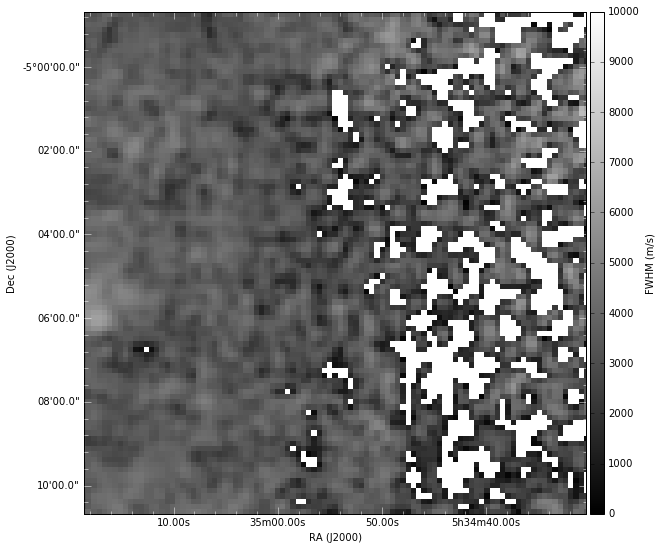

In [4]:
print(np.nanmedian(fwhm_map))

fig = FITSFigure(fwhm_map.hdu)
fig.show_grayscale(vmin=0, vmax=10000)
fig.recenter(83.72707, -5.07792, 0.1)
fig.show_colorbar()
fig.colorbar.set_axis_label_text("FWHM (m/s)")

### Smooth the Velocity FWHM Map For a Global Estimate of FWHM in Orion A

3807.08921001


INFO: Auto-setting vmin to -2.152e+03 [aplpy.core]
INFO: Auto-setting vmax to  2.841e+04 [aplpy.core]


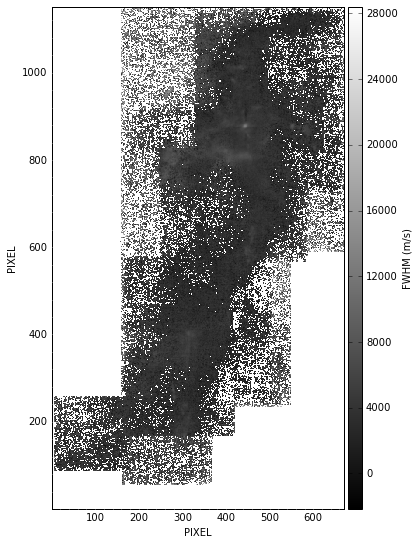

In [5]:
from scipy.ndimage.filters import gaussian_filter
fwhm_smooth = gaussian_filter(fwhm_map.data, 0)
print(np.nanmedian(fwhm_smooth))
fig = FITSFigure(fwhm_smooth)
fig.show_grayscale()
#fig.recenter(83.72707, -5.07792, 0.1)
fig.show_colorbar()
fig.colorbar.set_axis_label_text("FWHM (m/s)")

### Plot an example turbulent model cube.

In [6]:
# For Shell 18
n=17
shell_list = shells.get_shells()
shell = shell_list[n]

outfile = '../turbulent_model/shell18_nocloud.fits'
model_pars = {
    'outfile':"'{}'".format(outfile),
    'dist':414, # pc
    'pix_size':7.5, # arcsec
    'vstep':0.099, # km/s
    'acen':shell.ra.value, # deg
    'dcen':shell.dec.value, # deg
    'thickness':0.0, # pc
    'fwhm':0.0, # km/s
    'beta':0.0, # spectral index
    'r':0.22, # pc
    'dr':0.2, # pc
    'vexp':2.2, # km/s
    'depth_offset':0.0, # pc
    'vel_offset':0.0, # km/s
    'v0':13.6, # km/s
    'ignore_cloud':1 #Ignore cloud.
             }
idl_arg_list = ["{}={}".format(k, v) for k, v in model_pars.items()]

idl_arg_string = ', '.join(idl_arg_list)
#call_string = "idl << EOF \n" +\
#              ".r turbulent_model \n" +\
#              "turbulent_model, {} \n".format(idl_arg_string) +\
#              "EOF"
call_string = 'idl -e "turbulent_model, {}"'.format(idl_arg_string)

In [7]:
#Call the idl program turbulent_model.pro with the above parameters
e = os.system(call_string)

### Integrated Intensity (Column Density) of Model Shell

In [8]:
model_cube = SpectralCube.read(outfile)
model_mom0 = model_cube.moment0()

INFO: Auto-setting vmin to -7.532e-01 [aplpy.core]
INFO: Auto-setting vmax to  8.361e+00 [aplpy.core]


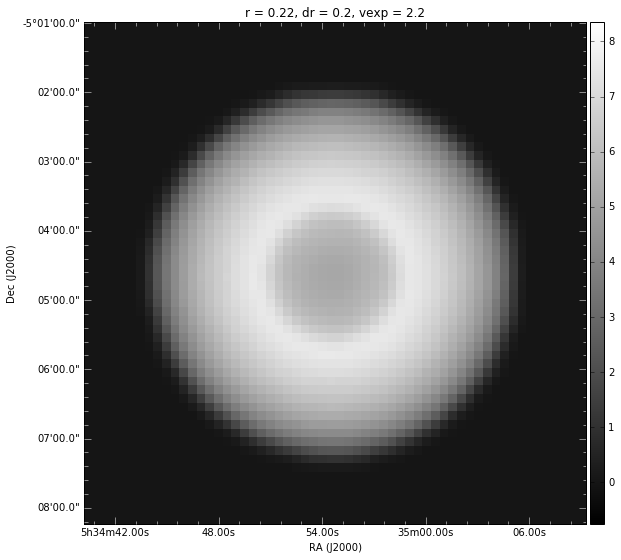

In [9]:
fig = FITSFigure(model_mom0.hdu)
fig.show_grayscale()
cb = fig.show_colorbar()
fig.set_title("r = {}, dr = {}, vexp = {}".format(model_pars['r'], model_pars['dr'], model_pars['vexp']))

### Extract a subcube around an Orion A shell

In [10]:
n = 17
shell_list = shells.get_shells()
subcubes = shells.subcubes_from_ds9(cube=cubefile12co, region_file=regionfile, pad_factor=1.5, shape='square')
shell = shell_list[n]
shell_subcube = subcubes[n].spectral_slab(shell.vmin, shell.vmax)
shell_mom0 = shell_subcube.moment0()

INFO: Auto-setting vmin to -9.160e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.793e+04 [aplpy.core]


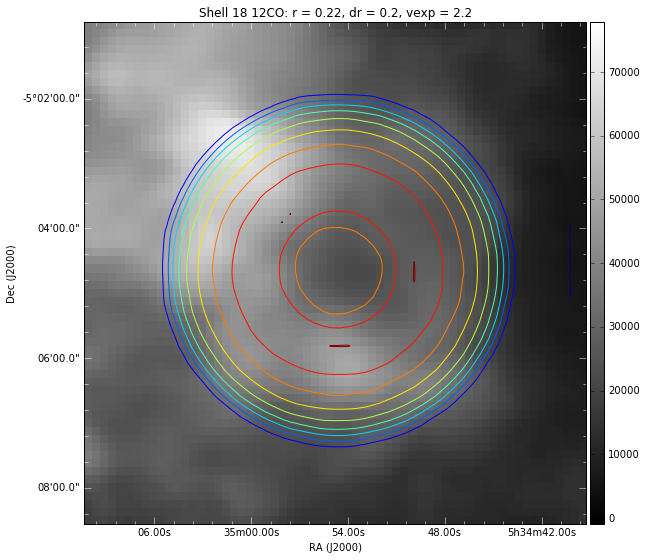

In [11]:
fig = FITSFigure(shell_mom0.hdu)
fig.show_grayscale()
cb = fig.show_colorbar()
fig.set_title("Shell 18 12CO: r = {}, dr = {}, vexp = {}".format(model_pars['r'], model_pars['dr'], model_pars['vexp']))
fig.show_contour(model_mom0.hdu, levels=10)

In [12]:
model_profile, model_profile_error, model_bins = shell_model.radial_profile(np.array(model_mom0), nbins=30)
model_profile_alongx, model_r_alongx = shell_model.radial_profile(
    np.array(model_mom0), removeNaN=False, mode='along x')
shell_profile, shell_profile_error, shell_bins = shell_model.radial_profile(np.array(shell_mom0), nbins=30)
print(model_r_alongx)

(58, 58) (58, 58) (58, 58)
[[ 0  0  0 ...,  0  0  0]
 [ 1  1  1 ...,  1  1  1]
 [ 2  2  2 ...,  2  2  2]
 ..., 
 [55 55 55 ..., 55 55 55]
 [56 56 56 ..., 56 56 56]
 [57 57 57 ..., 57 57 57]] 28.0
[  0.70710678   0.70710678   1.58113883   2.54950976   3.53553391
   4.52769257   5.52268051   6.51920241   7.51664819   8.51469318
   9.5131488   10.51189802  11.51086443  12.509996    13.50925609
  14.50861813  15.50806242  16.50757402  17.5071414   18.50675552
  19.5064092   20.50609665  21.50581317  22.50555487  23.50531855
  24.50510151  25.50490149  26.50471656  27.50454508  28.50438563]


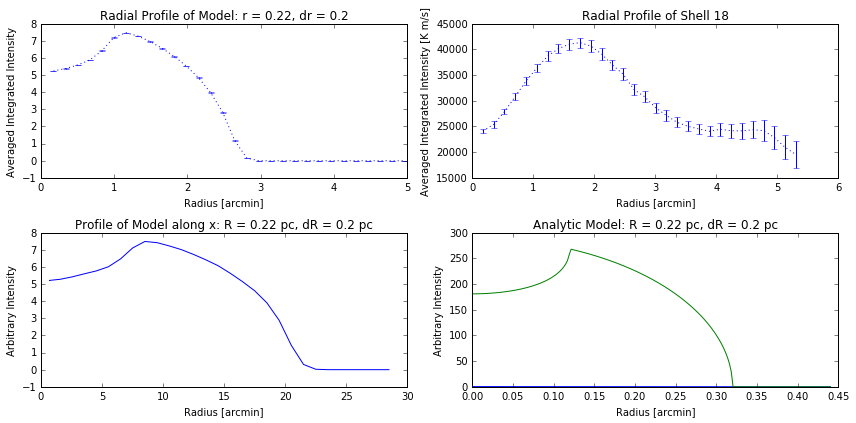

In [13]:
%autoreload 1
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(221)
ax1.errorbar(model_bins*model_pars['pix_size']/60., model_profile,
             yerr=model_profile_error, linestyle="dotted", label="S.E.M.")
ax1.set_xlabel("Radius [arcmin]")
ax1.set_ylabel("Averaged Integrated Intensity")
ax1.set_title("Radial Profile of Model: r = {}, dr = {}".format(model_pars['r'], model_pars['dr']))

ax2 = fig.add_subplot(222)
ax2.errorbar(shell_bins*model_pars['pix_size']/60., shell_profile,
             yerr=shell_profile_error, linestyle="dotted", label="S.E.M.")
ax2.set_xlabel("Radius [arcmin]")
ax2.set_ylabel("Averaged Integrated Intensity [K m/s]")
ax2.set_title("Radial Profile of Shell {}".format(n+1))

ax3 = fig.add_subplot(223)
ax3.plot(model_r_alongx, model_profile_alongx, label="Radial Profile of Model (along x-axis)")
ax3.set_xlabel("Radius [arcmin]")
ax3.set_ylabel("Arbitrary Intensity")
ax3.set_title("Profile of Model along x: R = {} pc, dR = {} pc".format(model_pars['r'], model_pars['dr']))

ax4 = fig.add_subplot(224)
analytic_r = np.linspace(0., 2.*model_pars['r'], 200)
analytic_profile = shell_model.analytic_profile(
    analytic_r, model_pars['r'], model_pars['dr'])

ax4.plot(analytic_r, analytic_profile, label="Analytic Model")
ax4.plot(analytic_r,
         gaussian_filter(analytic_profile,
                         model_pars['dist'] * 3 * model_pars['pix_size']/206265.) / (analytic_r[1] - analytic_r[0]))
ax4.set_xlabel("Radius [arcmin]")
ax4.set_ylabel("Arbitrary Intensity")
ax4.set_title("Analytic Model: R = {} pc, dR = {} pc".format(model_pars['r'], model_pars['dr']))
#print(analytic_profile)
fig.tight_layout()

### Plot the normalized profiles against each other.

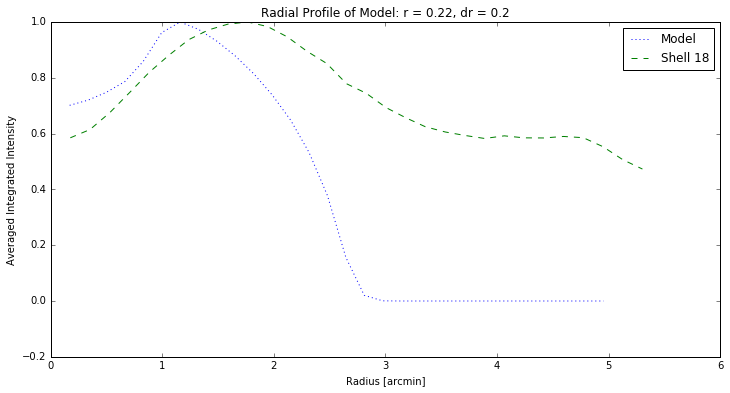

In [14]:
fig = plt.figure(figsize=(12,6))
plt.plot(model_bins*model_pars['pix_size']/60., model_profile/np.nanmax(model_profile),
             linestyle="dotted", label="Model")
plt.plot(shell_bins*model_pars['pix_size']/60., shell_profile/np.nanmax(shell_profile),
             linestyle="dashed", label="Shell 18")
plt.xlabel("Radius [arcmin]")
plt.ylabel("Averaged Integrated Intensity")
plt.legend()
plt.title("Radial Profile of Model: r = {}, dr = {}".format(model_pars['r'], model_pars['dr']))

## Modeling Shell Position-Velocity Diagrams

### Comparison of Model and Observed Shell P-V Cut

In [15]:
#n = 4 #Shell 18
shell = shell_list[n]
subcube = subcubes[n]
pix_size = subcube.spatial_coordinate_map[0][1,0] - subcube.spatial_coordinate_map[0][0,0]
pv_angle = 100 * u.deg
pv_width, pv_length = 3 * pix_size, 3 * shell.radius
pv_obs, path = shells.pv_slice(cube=subcube, ra_center=shell.ra, dec_center=shell.dec,
                     angle=pv_angle, width=pv_width, length=pv_length,
                     return_path=True)
pv_model = shells.pv_slice(cube=model_cube, ra_center=shell.ra, dec_center=shell.dec,
                          angle=pv_angle, width=pv_width, length=pv_length)


INFO: Auto-setting vmin to -5.589e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.575e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.780e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.976e+01 [aplpy.core]


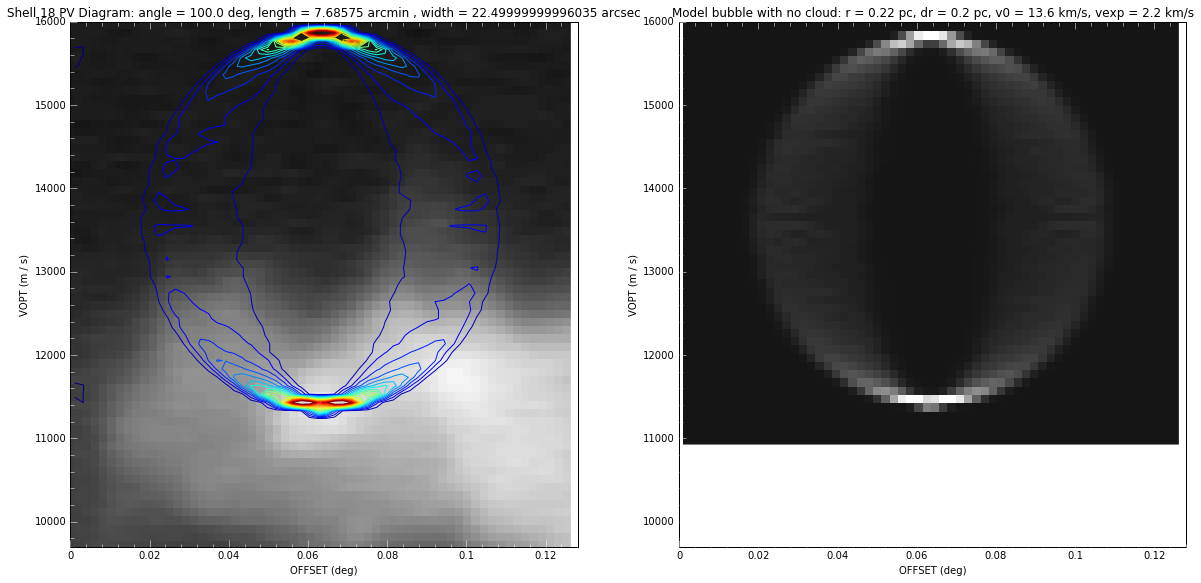

In [16]:
fig = plt.figure(figsize=(20,10))
obsfig = FITSFigure(pv_obs, figure=fig, subplot=(1,2,1))
obsfig.show_grayscale()
obsfig.show_contour(pv_model, levels=20)
obsfig.recenter(pv_length.value / 2., 1000. * (shell.vmax.value + shell.vmin.value) / 2.,
                width=pv_length.value, height = 3*1000*(shell.vmax.value - shell.vmin.value))
obsfig.set_title("Shell {} PV Diagram: angle = {}, length = {} , width = {}".format(
                 n+1, pv_angle, pv_length.to(u.arcmin), pv_width.to(u.arcsec)))

modelfig = FITSFigure(pv_model, figure=fig, subplot=(1,2,2))
modelfig.show_grayscale()
modelfig.set_title(
    "Model bubble with no cloud: r = {} pc, dr = {} pc, v0 = {} km/s, vexp = {} km/s".format(
        model_pars['r'], model_pars['dr'], model_pars['v0'], model_pars['vexp']))
modelfig.recenter(pv_length.value / 2., 1000. * (shell.vmax.value + shell.vmin.value) / 2.,
                width=pv_length.value, height = 3*1000*(shell.vmax.value - shell.vmin.value))
#fig.show_grayscale()

Assuming the position of bubble and the observation parameters stay fixed. The bubble-only model shown above depends should only depend on **v0**, **vexp**, **r**, and **dr**. May need to also fit for the bubble center, **acen** and **dcen**.

### Comparing Azimuthally Averaged P-V Diagrams
Rotate slices through the shell center and find the average P-V diagram.

In [17]:
def pv_average(cube=None, ra_center=None, dec_center=None,
    width=22.5*u.arcsec, length=5*u.arcmin,
    angle_range=[0*u.deg, 360.*u.deg], angle_step=10*u.deg,
    mode='average'):
    """Returns a postion-velocity slice of `cube` from pvextractor,
    averaged over `angle`. If `angle_step` == None, step by `width`
    """
    import shells
    import numpy as np
    from astropy.io import fits
    
    angle_list = np.linspace(angle_range[0], angle_range[1],
                             (angle_range[1] + angle_step) / angle_step)
    pv_list = [shells.pv_slice(cube=cube, ra_center=ra_center, dec_center=dec_center,
                               angle=angle, width=width, length=length)
               for angle in angle_list]
    if mode == 'average':
        average_data = np.mean(np.array([hdu.data for hdu in pv_list]), axis=0)
        print(average_data.shape)
        average_HDU = fits.PrimaryHDU(average_data, header=pv_list[0].header)
        return average_HDU


In [18]:
pv_average_obs = pv_average(
    cube=subcube.spectral_slab(model_cube.spectral_extrema[0], model_cube.spectral_extrema[1]),
    ra_center=shell.ra, dec_center=shell.dec,
    width=pv_width, length=pv_length, angle_step=10*u.deg)







































(55, 61)


INFO: Auto-setting vmin to -4.847e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.507e+01 [aplpy.core]
INFO: Auto-setting vmin to -1.780e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.976e+01 [aplpy.core]


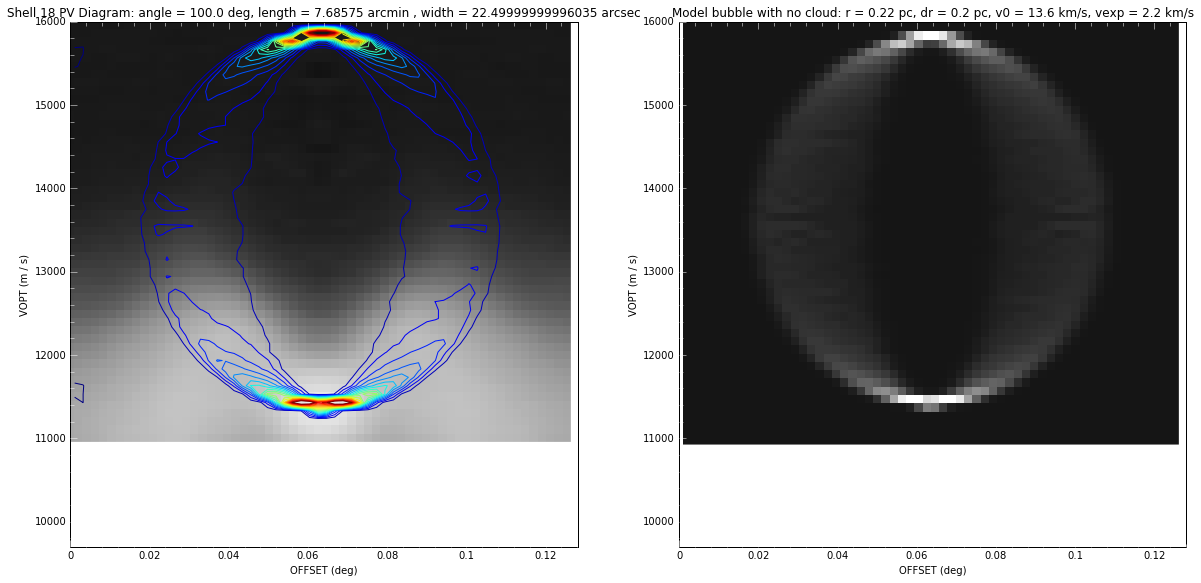

In [19]:
fig = plt.figure(figsize=(20,10))
obsfig = FITSFigure(pv_average_obs, figure=fig, subplot=(1,2,1))
obsfig.show_grayscale()
obsfig.show_contour(pv_model, levels=20)
obsfig.recenter(pv_length.value / 2., 1000. * (shell.vmax.value + shell.vmin.value) / 2.,
                width=pv_length.value, height = 3*1000*(shell.vmax.value - shell.vmin.value))
obsfig.set_title("Shell {} PV Diagram: angle = {}, length = {} , width = {}".format(
                 n+1, pv_angle, pv_length.to(u.arcmin), pv_width.to(u.arcsec)))

modelfig = FITSFigure(pv_model, figure=fig, subplot=(1,2,2))
modelfig.show_grayscale()
modelfig.set_title(
    "Model bubble with no cloud: r = {} pc, dr = {} pc, v0 = {} km/s, vexp = {} km/s".format(
        model_pars['r'], model_pars['dr'], model_pars['v0'], model_pars['vexp']))
modelfig.recenter(pv_length.value / 2., 1000. * (shell.vmax.value + shell.vmin.value) / 2.,
                width=pv_length.value, height = 3*1000*(shell.vmax.value - shell.vmin.value))
#fig.show_grayscale()

Only compute residuals with observed pixels containing significant emission. 

### Compute PV pixel residuals

In [20]:
pv_model_norm = pv_model.data / np.nanmax(pv_model.data)
pv_obs_norm = pv_average_obs.data / np.nanmax(pv_average_obs.data)
pv_resid =  pv_obs_norm - pv_model_norm
pv_resid[pv_obs_norm < 0.01] = np.nan

resid_squared = pv_resid ** 2.

INFO: Auto-setting vmin to -8.133e-02 [aplpy.core]
INFO: Auto-setting vmax to  9.027e-01 [aplpy.core]
INFO: Auto-setting vmin to -1.165e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.083e+00 [aplpy.core]
INFO: Auto-setting vmin to -2.414e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.066e+00 [aplpy.core]
INFO: Auto-setting vmin to -8.968e-02 [aplpy.core]
INFO: Auto-setting vmax to  9.954e-01 [aplpy.core]
RMS Residual = 0.468357116381


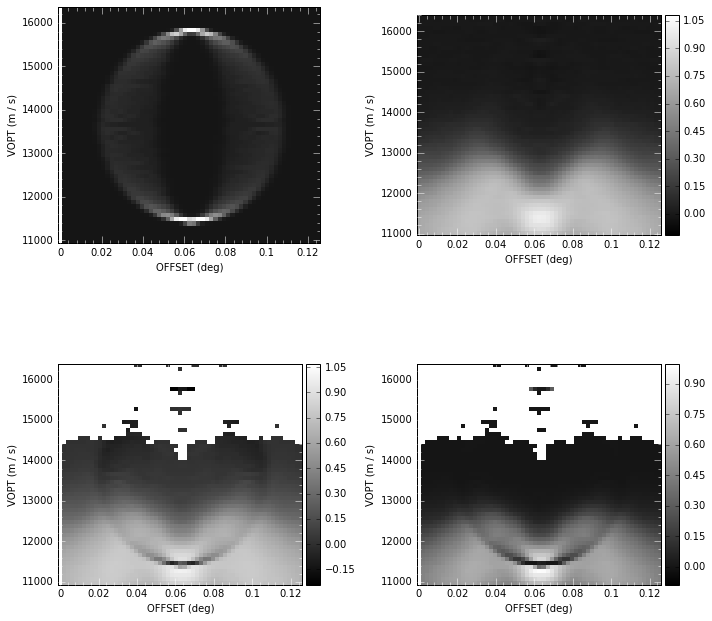

In [21]:
#pv_resid = pv_model_norm[np.isfinite(pv_model_norm)] - pv_obs_norm[np.isfinite(pv_model_norm)]
#pv_model_norm.resize(pv_obs_norm.shape)
fig = plt.figure(figsize=(10,10))
#ax1 = fig.add_subplot(221)
#ax1.imshow(pv_model_norm, interpolation='none')
modelfig = FITSFigure(fits.PrimaryHDU(pv_model_norm, header=pv_model.header), figure=fig, subplot=(2,2,1))
modelfig.show_grayscale()
#ax2 = fig.add_subplot(222)
obsfig = FITSFigure(fits.PrimaryHDU(pv_obs_norm, header=pv_average_obs.header), figure=fig, subplot=(2,2,2))
obsfig.show_grayscale()
obsfig.show_colorbar()
#ax3 = fig.add_subplot(223)
residfig = FITSFigure(fits.PrimaryHDU(pv_resid, header=pv_model.header), figure=fig, subplot=(2,2,3))
residfig.show_grayscale()
residfig.show_colorbar()
#ax4 = fig.add_subplot(224)
#ax4.imshow(pv_resid_above5percent, interpolation='none')
resid2fig = FITSFigure(fits.PrimaryHDU(resid_squared, header=pv_model.header), figure=fig, subplot=(2,2,4))
resid2fig.show_grayscale()
resid2fig.show_colorbar()
plt.tight_layout()
print("RMS Residual =", np.sqrt(np.nanmean(resid_squared)))
#fig.show_grayscale()

### Run a grid of models.

In [22]:
dist = 414 * u.pc
pix_pc = dist * pix_size.to(u.radian).value
dv = 0.1 * u.km/u.s
R = dist * shell.radius.to(u.radian).value
dR = R
vexp = shell.vmax - shell.vmin

In [23]:
vexp_grid = np.arange(0.5*vexp.to(u.km/u.s).value, 2*vexp.to(u.km/u.s).value, 2. * dv.to(u.km/u.s).value)
print(vexp_grid)
v0_grid = np.arange(0.8*shell.vmin.to(u.km/u.s).value, 1.2*shell.vmax.to(u.km/u.s).value, 2. * dv.to(u.km/u.s).value)
R_grid = np.arange(0.5 * R.to(u.pc).value, 2 * R.to(u.pc).value, 3. * pix_pc.value)
dR_grid = R_grid

[ 1.05  1.25  1.45  1.65  1.85  2.05  2.25  2.45  2.65  2.85  3.05  3.25
  3.45  3.65  3.85  4.05]


In [24]:
(vexp_grid.size * v0_grid.size * R_grid.size * dR_grid.size)*1.65 / 3600. / 24.

1.3679722222222221

In [25]:
box_size = 3
den = np.zeros(3*[box_size])
center = 3*[np.floor(box_size / 2)]
center

[1.0, 1.0, 1.0]

In [26]:
x, y, z = np.indices(3*[box_size]) - center[0] 
rr = np.sqrt(x**2 + y**2 + z**2) * pix_pc 

In [27]:
vel = vexp * z * pix_pc / rr
vel[rr == 0] = 0
vcen = np.linspace(-1.*vexp, vexp, 2*vexp / dv)
print(vcen)

[-2.1   -1.995 -1.89  -1.785 -1.68  -1.575 -1.47  -1.365 -1.26  -1.155
 -1.05  -0.945 -0.84  -0.735 -0.63  -0.525 -0.42  -0.315 -0.21  -0.105  0.
  0.105  0.21   0.315  0.42   0.525  0.63   0.735  0.84   0.945  1.05
  1.155  1.26   1.365  1.47   1.575  1.68   1.785  1.89   1.995  2.1  ] km / s


In [28]:
vcen - np.roll(vcen, 1)

<Quantity [-4.2  , 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105,
            0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105,
            0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105,
            0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105, 0.105,
            0.105, 0.105, 0.105, 0.105, 0.105] km / s>

### Compare Python Model Output to IDL Output

Because running a grid of models from the IDL code would take too long, I re-wrote a no-cloud model in Python. The big time saver is the I/O of fits files of each model. Here, I compare the results of the IDL and Python models.

In [29]:
# For Shell 18
n=17
shell_list = shells.get_shells()
shell = shell_list[n]

outfile = '../turbulent_model/idl_model.fits'
model_pars = {
    'outfile':"'{}'".format(outfile),
    'dist':414, # pc
    'pix_size':7.5, # arcsec
    'vstep':0.099, # km/s
    'acen':shell.ra.value, # deg
    'dcen':shell.dec.value, # deg
    'thickness':0.0, # pc
    'fwhm':0.0, # km/s
    'beta':0.0, # spectral index
    'r':0.22, # pc
    'dr':0.2, # pc
    'vexp':2.2, # km/s
    'depth_offset':0.0, # pc
    'vel_offset':0.0, # km/s
    'v0':13.6, # km/s
    'ignore_cloud':1 #Ignore cloud.
             }

### Run IDL Model

In [30]:
idl_arg_list = ["{}={}".format(k, v) for k, v in model_pars.items()]

idl_arg_string = ', '.join(idl_arg_list)
#call_string = "idl << EOF \n" +\
#              ".r turbulent_model \n" +\
#              "turbulent_model, {} \n".format(idl_arg_string) +\
#              "EOF"
call_string = 'idl -e "turbulent_model, {}"'.format(idl_arg_string)
#Call the idl program turbulent_model.pro with the above parameters
e = os.system(call_string)

### Run Python Model

In [31]:
ppv, den, vel = shell_model.ppv_model(dist=model_pars['dist']*u.pc, pix_size=model_pars['pix_size']*u.arcsec,
                                             vstep=model_pars['vstep']*u.km/u.s, acen=shell.ra, dcen=shell.dec,
                                             r=model_pars['r']*u.pc, dr=model_pars['dr']*u.pc,
                                             vexp=model_pars['vexp']*u.km/u.s, v0=model_pars['v0']*u.km/u.s)

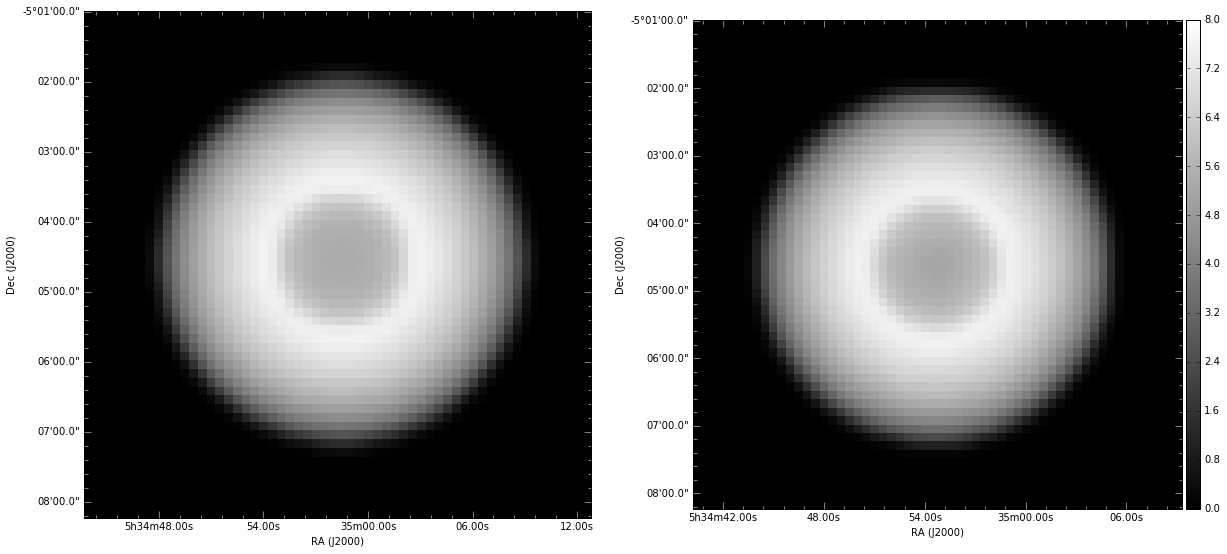

In [32]:
cube_py, cube_idl = SpectralCube.read(ppv), SpectralCube.read(outfile)
fig = plt.figure(figsize=(20,10))
#ax1 = fig.add_subplot(221)
#ax1.imshow(pv_model_norm, interpolation='none')
modelfig = FITSFigure(cube_py.moment0().hdu, figure=fig, subplot=(1,2,1))
modelfig.show_grayscale(vmin=0., vmax=8)
#ax2 = fig.add_subplot(222)
obsfig = FITSFigure(cube_idl.moment0().hdu, figure=fig, subplot=(1,2,2))
obsfig.show_grayscale(vmin=0., vmax=8)
obsfig.show_colorbar()

In [33]:
pv_average_obs = pv_average(
    cube=subcube.spectral_slab(model_cube.spectral_extrema[0], model_cube.spectral_extrema[1]),
    ra_center=shell.ra, dec_center=shell.dec,
    width=pv_width, length=pv_length, angle_step=10*u.deg)
pv_average_idl = pv_average(
    cube=cube_idl,
    ra_center=shell.ra, dec_center=shell.dec,
    width=pv_width, length=pv_length, angle_step=10*u.deg)
pv_average_py = pv_average(
    cube=cube_py,
    ra_center=shell.ra, dec_center=shell.dec,
    width=pv_width, length=pv_length, angle_step=10*u.deg)






































(55, 61)





































(55, 61)





































(44, 61)


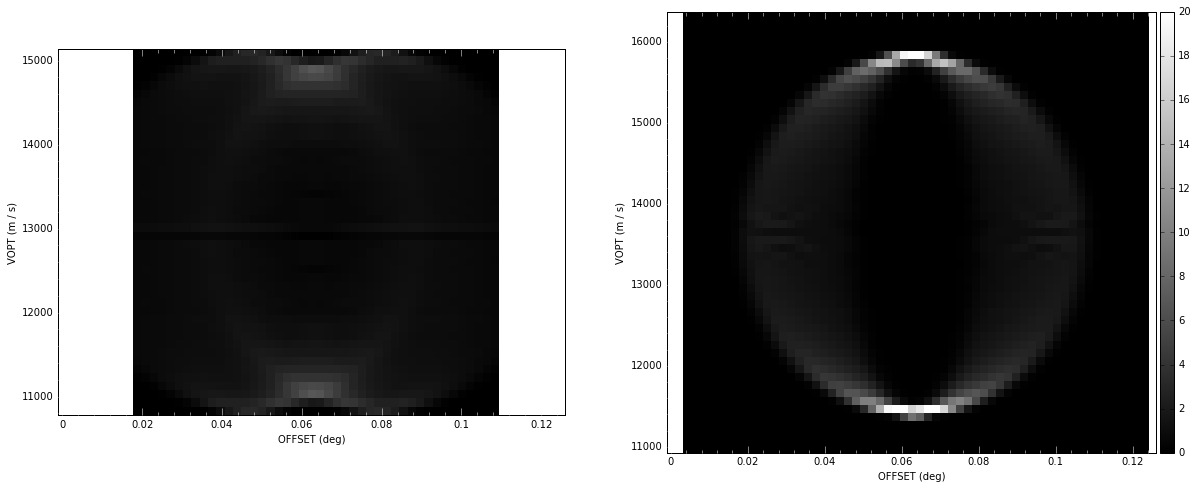

In [34]:
fig = plt.figure(figsize=(20,10))
#ax1 = fig.add_subplot(221)
#ax1.imshow(pv_model_norm, interpolation='none')
pyfig = FITSFigure(pv_average_py, figure=fig, subplot=(1,2,1))
pyfig.show_grayscale(vmin=0, vmax=20)
#ax2 = fig.add_subplot(222)
idlfig = FITSFigure(pv_average_idl, figure=fig, subplot=(1,2,2))
idlfig.show_grayscale(vmin=0, vmax=20)
idlfig.show_colorbar()

### Compare IDL and Python model Run Times

In [35]:
outfile = '../turbulent_model/idl_model.fits'
model_pars = {
    'outfile':"'{}'".format(outfile),
    'dist':414, # pc
    'pix_size':7.5, # arcsec
    'vstep':0.099, # km/s
    'acen':shell.ra.value, # deg
    'dcen':shell.dec.value, # deg
    'thickness':0.0, # pc
    'fwhm':0.0, # km/s
    'beta':0.0, # spectral index
    'r':0.22, # pc
    'dr':0.05, # pc
    'vexp':2.2, # km/s
    'depth_offset':0.0, # pc
    'vel_offset':0.0, # km/s
    'v0':13.6, # km/s
    'ignore_cloud':1, #Ignore cloud.
    'write_fits':1,
    'save_ppv':0
    }

In [36]:
idl_arg_list = ["{}={}".format(k, v) for k, v in model_pars.items()]
idl_arg_string = ', '.join(idl_arg_list)
call_string = 'idl -e "turbulent_model, {}"'.format(idl_arg_string)
e = os.system(call_string)

In [37]:
model_pars['write_fits'] = 0
model_pars['save_ppv'] = 1
outfile = '../turbulent_model/ppv.sav'
model_pars['outfile'] = "'{}'".format(outfile)

idl_arg_list = ["{}={}".format(k, v) for k, v in model_pars.items()]
idl_arg_string = ', '.join(idl_arg_list)
call_string = 'idl -e "turbulent_model, {}"'.format(idl_arg_string)
%timeit e = os.system(call_string)

1.45 s ± 53.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit ppv, den, vel = shell_model.ppv_model(dist=model_pars['dist']*u.pc, pix_size=model_pars['pix_size']*u.arcsec,\
                                             vstep=model_pars['vstep']*u.km/u.s, acen=shell.ra, dcen=shell.dec,\
                                             r=model_pars['r']*u.pc, dr=model_pars['dr']*u.pc,\
                                             vexp=model_pars['vexp']*u.km/u.s, v0=model_pars['v0']*u.km/u.s)

156 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Does increasing the resolution of the working cube change the result?

In [41]:
ppv5, den5, vel5 = shell_model.ppv_model(dist=model_pars['dist']*u.pc, pix_size=model_pars['pix_size']*u.arcsec,\
                                             vstep=model_pars['vstep']*u.km/u.s, acen=shell.ra, dcen=shell.dec,\
                                             r=model_pars['r']*u.pc, dr=model_pars['dr']*u.pc,\
                                             vexp=model_pars['vexp']*u.km/u.s, v0=model_pars['v0']*u.km/u.s,\
                                             working_grid_factor = 5)
ppv2, den2, vel2 = shell_model.ppv_model(dist=model_pars['dist']*u.pc, pix_size=model_pars['pix_size']*u.arcsec,\
                                             vstep=model_pars['vstep']*u.km/u.s, acen=shell.ra, dcen=shell.dec,\
                                             r=model_pars['r']*u.pc, dr=model_pars['dr']*u.pc,\
                                             vexp=model_pars['vexp']*u.km/u.s, v0=model_pars['v0']*u.km/u.s,\
                                             working_grid_factor = 2)

cube_5, cube_2 = SpectralCube.read(ppv5), SpectralCube.read(ppv2)

In [42]:
pv_2 = pv_average(
    cube=cube_2,
    ra_center=shell.ra, dec_center=shell.dec,
    width=pv_width, length=pv_length, angle_step=10*u.deg)
pv_5 = pv_average(
    cube=cube_5,
    ra_center=shell.ra, dec_center=shell.dec,
    width=pv_width, length=pv_length, angle_step=10*u.deg)






































(44, 61)





































(44, 61)


INFO: Auto-setting vmin to -2.295e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.547e+00 [aplpy.core]
INFO: Auto-setting vmin to -5.521e-01 [aplpy.core]
INFO: Auto-setting vmax to  6.128e+00 [aplpy.core]


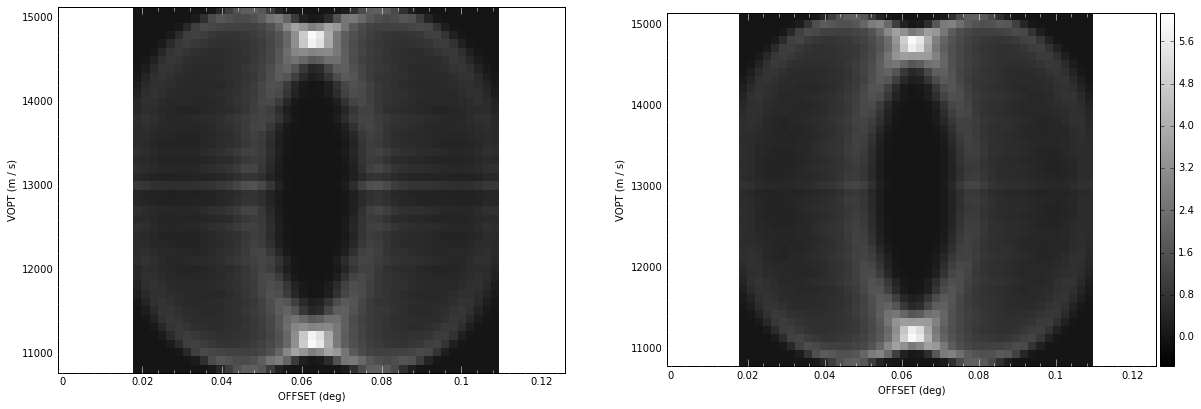

In [43]:
fig = plt.figure(figsize=(20,10))
#ax1 = fig.add_subplot(221)
#ax1.imshow(pv_model_norm, interpolation='none')
fig1 = FITSFigure(pv_2, figure=fig, subplot=(1,2,1))
fig1.show_grayscale()
#ax2 = fig.add_subplot(222)
fig2 = FITSFigure(pv_5, figure=fig, subplot=(1,2,2))
fig2.show_grayscale()
fig2.show_colorbar()

The sampling artifacts are suppressed in the PV diagram when working on a cube at 5X higher resolution than the final cube (right) vs. an oversampling of 2X (left). But the strange overall morphology of the PV diagrams remains.

### Testing IDL Model's Velocity Interpolation Step
The IDL program `ppp2ppv.pro` takes 3D density and velocity cubes and makes a PPV cube with the requested velocity channel binning. My implementation (in `shell_model.ppp2ppv`) makes a weighted histogram of voxel velocities along each column (z-axis) through the 3D cube. Each voxel is weighted by its density. Each weighted histogram is a spectrum at one (x,y) position.

The IDL model implements an interpolation scheme that basically smooths these histograms. My Python model doesn't do any such interpolation. I suspect this step may explain the different results shown clearly in the model PV diagrams above.

Here, I will test a version of my `shell_model.ppp2ppv` that clones the IDL model's interpolation step.

In [44]:
%reload_ext
ppv_interp, den_interp, vel_interp = shell_model.ppv_model(dist=model_pars['dist']*u.pc, pix_size=model_pars['pix_size']*u.arcsec,\
                                             vstep=model_pars['vstep']*u.km/u.s, acen=shell.ra, dcen=shell.dec,\
                                             r=model_pars['r']*u.pc, dr=model_pars['dr']*u.pc,\
                                             vexp=model_pars['vexp']*u.km/u.s, v0=model_pars['v0']*u.km/u.s,\
                                     interpolate_ppv=True)


IndexError: too many indices for array